In [1]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format
!conda install -c conda-forge nibabel
!conda install -c conda-forge opencv


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import cv2 as cv
import os
import tensorflow as tf
import tensorflow_addons as tfa
#%tensorflow_version 2.x

import math
import timeit
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

#from tqdm import tqdm_notebook, tnrange
#from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import skimage as sk
from sklearn.model_selection import train_test_split

#import nibabel as nib

In [2]:
print(tf.__version__)

2.1.0


In [3]:
# Set up some global variables
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /device:GPU:0


In [4]:
# print(X[:amount].shape,X[amount:].shape)
# print(y[:amount].shape)

In [5]:
X_train = np.load('X_train.npy')
X_train = X_train.reshape(1360, 176, 224,1)
y_train = np.load('y_train.npy')
y_train = y_train.reshape(1360, 176, 224,1)
X_val = np.load('X_val.npy')
X_val = X_val.reshape(266, 176, 224,1)
y_val = np.load('y_val.npy')
y_val = y_val.reshape(266, 176, 224,1)
X_test = np.load('X_test.npy')
X_test = X_test.reshape(276, 176, 224,1)
y_test = np.load('y_test.npy')
y_test = y_test.reshape(276, 176, 224,1)


In [6]:
print(X_train.shape,X_val.shape,X_test.shape)
print(y_train.shape,y_val.shape,y_test.shape)

(1360, 176, 224, 1) (266, 176, 224, 1) (276, 176, 224, 1)
(1360, 176, 224, 1) (266, 176, 224, 1) (276, 176, 224, 1)


In [7]:
print(np.unique(y_train))

[0.         0.33333333 0.66666667 1.        ]


In [8]:
y_train[abs(y_train-0)<0.001] = 0
y_train[abs(y_train-1)<0.001] = 3
y_train[abs(y_train-0.333)<0.001] = 1
y_train[abs(y_train-0.666)<0.001] = 2
y_val[abs(y_val-0)<0.001] = 0
y_val[abs(y_val-1)<0.001] = 3
y_val[abs(y_val-0.333)<0.001] = 1
y_val[abs(y_val-0.666)<0.001] = 2
y_test[abs(y_test-0)<0.001] = 0
y_test[abs(y_test-1)<0.001] = 3
y_test[abs(y_test-0.333)<0.001] = 1
y_test[abs(y_test-0.666)<0.001] = 2


In [9]:
print(np.unique(y_train), np.unique(y_val), np.unique(y_test))

[0. 1. 2. 3.] [0. 1. 2. 3.] [0. 1. 2. 3.]


In [10]:
class UNet(tf.keras.Model):
    def __init__(self, start_neurons):
        super(UNet, self).__init__()
        
        initializer = tf.initializers.VarianceScaling(scale=2.0)
        
        self.conv11 = tf.keras.layers.Conv2D(start_neurons*1, 3, activation='relu',padding='same', kernel_initializer=initializer)
        self.instnorm11 = tfa.layers.InstanceNormalization(axis=3, 
                                   center=True, 
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform")
        self.conv12 = tf.keras.layers.Conv2D(start_neurons*1, 3, activation='relu',padding='same', kernel_initializer=initializer)
        self.instnorm12 = tfa.layers.InstanceNormalization(axis=3, 
                                   center=True, 
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform")
        self.pool1 = tf.keras.layers.MaxPool2D((2,2))

        self.conv21 = tf.keras.layers.Conv2D(start_neurons*2, 3, activation='relu',padding='same', kernel_initializer=initializer)
        self.instnorm21 = tfa.layers.InstanceNormalization(axis=3, 
                                   center=True, 
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform")
        self.conv22 = tf.keras.layers.Conv2D(start_neurons*2, 3, activation='relu',padding='same', kernel_initializer=initializer)
        self.instnorm22 = tfa.layers.InstanceNormalization(axis=3, 
                                   center=True, 
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform")
        self.pool2 = tf.keras.layers.MaxPool2D((2,2))

        self.conv31 = tf.keras.layers.Conv2D(start_neurons*4, 3, activation='relu',padding='same', kernel_initializer=initializer)
        self.instnorm31 = tfa.layers.InstanceNormalization(axis=3, 
                                   center=True, 
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform")
        self.conv32 = tf.keras.layers.Conv2D(start_neurons*4, 3, activation='relu',padding='same', kernel_initializer=initializer)
        self.instnorm32 = tfa.layers.InstanceNormalization(axis=3, 
                                   center=True, 
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform")
        self.pool3 = tf.keras.layers.MaxPool2D((2,2))

        self.conv41 = tf.keras.layers.Conv2D(start_neurons*8, 3, activation='relu',padding='same', kernel_initializer=initializer)
        self.instnorm41 = tfa.layers.InstanceNormalization(axis=3, 
                                   center=True, 
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform")
        self.conv42 = tf.keras.layers.Conv2D(start_neurons*8, 3, activation='relu',padding='same', kernel_initializer=initializer)
        self.instnorm42 = tfa.layers.InstanceNormalization(axis=3, 
                                   center=True, 
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform")
        self.pool4 = tf.keras.layers.MaxPool2D((2,2))

        self.convm1 = tf.keras.layers.Conv2D(start_neurons * 16, 3, activation="relu", padding="same", kernel_initializer=initializer)
        self.instnormm1 = tfa.layers.InstanceNormalization(axis=3, 
                                   center=True, 
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform") 
        self.convm2 = tf.keras.layers.Conv2D(start_neurons * 16, 3, activation="relu", padding="same",kernel_initializer=initializer)
        self.instnormm2 = tfa.layers.InstanceNormalization(axis=3, 
                                   center=True, 
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform")
        
        self.deconv4 = tf.keras.layers.Conv2DTranspose(start_neurons * 8, 3, strides=(2, 2), padding="same", kernel_initializer=initializer)
        self.deconv_instnorm41 = tfa.layers.InstanceNormalization(axis=3, 
                                   center=True, 
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform")
        self.uconv41 = tf.keras.layers.Concatenate()
        self.uconv42 = tf.keras.layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same",kernel_initializer=initializer)
        self.uconv_instnorm41 = tfa.layers.InstanceNormalization(axis=3, 
                                   center=True, 
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform")
        self.uconv43 = tf.keras.layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same",kernel_initializer=initializer)
        self.uconv_instnorm42 = tfa.layers.InstanceNormalization(axis=3, 
                                   center=True, 
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform")
        
        self.deconv3 = tf.keras.layers.Conv2DTranspose(start_neurons * 4, 3, strides=(2, 2), padding="same", kernel_initializer=initializer)
        self.deconv_instnorm31 = tfa.layers.InstanceNormalization(axis=3, 
                                   center=True, 
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform")
        self.uconv31 = tf.keras.layers.Concatenate()
        self.uconv32 = tf.keras.layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same",kernel_initializer=initializer)
        self.uconv_instnorm31 = tfa.layers.InstanceNormalization(axis=3, 
                                   center=True, 
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform")
        self.uconv33 = tf.keras.layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same",kernel_initializer=initializer)
        self.uconv_instnorm32 = tfa.layers.InstanceNormalization(axis=3, 
                                   center=True, 
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform")
        
        self.deconv2 = tf.keras.layers.Conv2DTranspose(start_neurons * 2, 3, strides=(2, 2), padding="same", kernel_initializer=initializer)
        self.deconv_instnorm21 = tfa.layers.InstanceNormalization(axis=3, 
                                   center=True, 
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform")
        self.uconv21 = tf.keras.layers.Concatenate()
        self.uconv22 = tf.keras.layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same",kernel_initializer=initializer)
        self.uconv_instnorm21 = tfa.layers.InstanceNormalization(axis=3, 
                                   center=True, 
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform")
        self.uconv23 = tf.keras.layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same",kernel_initializer=initializer)
        self.uconv_instnorm22 = tfa.layers.InstanceNormalization(axis=3, 
                                   center=True, 
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform")
        
        self.deconv1 = tf.keras.layers.Conv2DTranspose(start_neurons * 1, 3, strides=(2, 2), padding="same", kernel_initializer=initializer)
        self.deconv_instnorm11 = tfa.layers.InstanceNormalization(axis=3, 
                                   center=True, 
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform")
        self.uconv11 = tf.keras.layers.Concatenate()
        self.uconv12 = tf.keras.layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same",kernel_initializer=initializer)
        self.uconv_instnorm11 = tfa.layers.InstanceNormalization(axis=3, 
                                   center=True, 
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform")
        self.uconv13 = tf.keras.layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same",kernel_initializer=initializer)
        self.uconv_instnorm12 = tfa.layers.InstanceNormalization(axis=3, 
                                   center=True, 
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform")
        
        self.output_layer = tf.keras.layers.Conv2D(4, 1, padding="same",activation="sigmoid",kernel_initializer=initializer)

        
    def call(self, x, training=False):
        x = self.conv11(x)
        x = self.instnorm11(x)
        x = self.conv12(x)
        x1 = self.instnorm12(x)
        x = self.pool1(x1)
        
        x = self.conv21(x)
        x = self.instnorm21(x)
        x = self.conv22(x)
        x2 = self.instnorm22(x)
        x = self.pool2(x2)
        
        x = self.conv31(x)
        x = self.instnorm31(x)
        x = self.conv32(x)
        x3 = self.instnorm32(x)
        x = self.pool3(x3)
        
        x = self.conv41(x)
        x = self.instnorm41(x)
        x = self.conv42(x)
        x4 = self.instnorm42(x)
        x = self.pool4(x4)
        
        x = self.convm1(x)
        x = self.instnormm1(x)
        x = self.convm2(x)
        x = self.instnormm2(x)
        
        x = self.deconv4(x)
        x = self.deconv_instnorm41(x)
        x = self.uconv41([x,x4])
        x = self.uconv42(x)
        x = self.uconv_instnorm41(x)
        x = self.uconv43(x)
        x = self.uconv_instnorm42(x)
        
        x = self.deconv3(x)
        x = self.deconv_instnorm31(x)
        x = self.uconv31([x,x3])
        x = self.uconv32(x)
        x = self.uconv_instnorm31(x)
        x = self.uconv33(x)
        x = self.uconv_instnorm32(x)
        
        x = self.deconv2(x)
        x = self.deconv_instnorm21(x)
        x = self.uconv21([x,x2])
        x = self.uconv22(x)
        x = self.uconv_instnorm21(x)
        x = self.uconv23(x)
        x = self.uconv_instnorm22(x)
        
        x = self.deconv1(x)
        x = self.deconv_instnorm11(x)
        x = self.uconv11([x,x1])
        x = self.uconv12(x)
        x = self.uconv_instnorm11(x)
        x = self.uconv13(x)
        x = self.uconv_instnorm12(x)
        
        scores = self.output_layer(x)     
        return scores

In [11]:
def model_init_fn():
    model = None
    model = UNet(start_neurons)
    return model

def optimizer_init_fn():
    optimizer = None
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    return optimizer

In [14]:
class Dataset(object):
    def __init__(self, X, y, batch_size, shuffle=False):
        assert X.shape[0] == y.shape[0], 'Got different numbers of data and labels'
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))

train_dset = Dataset(X_train, y_train, batch_size=32, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=32, shuffle=False)
test_dset = Dataset(X_test, y_test, batch_size=32, shuffle=False)
print(X_train.shape,y_train.shape)

(1360, 176, 224, 1) (1360, 176, 224, 1)


In [29]:
def train_part(model, optimizer, manager, num_epochs=1, is_training=False):   
    with tf.device(device):
        
        ckpt.restore(manager.latest_checkpoint)
        if manager.latest_checkpoint:
          print("Restored from {}".format(manager.latest_checkpoint))
        else:
          print("Initializing from scratch.")

        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
        
        train_loss = tf.keras.metrics.Mean(name='train_loss')
        train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
    
        val_loss = tf.keras.metrics.Mean(name='val_loss')
        val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')
        
        t = 0
        
        for epoch in range(num_epochs):
            
            train_loss.reset_states()
            train_accuracy.reset_states()
            
            for x_np, y_np in train_dset:
                with tf.GradientTape() as tape:
                    ckpt.step.assign_add(1)
                    scores = model(x_np, training=is_training)
                    loss = loss_fn(y_np, scores)
      
                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    
                    train_loss.update_state(loss)
                    train_accuracy.update_state(y_np, scores)
                    
                    if t % print_every == 0:
                        val_loss.reset_states()
                        val_accuracy.reset_states()
                        for test_x, test_y in val_dset:
                            # During validation at end of epoch, training set to False
                            prediction = model(test_x, training=False)
                            t_loss = loss_fn(test_y, prediction)

                            val_loss.update_state(t_loss)
                            val_accuracy.update_state(test_y, prediction)
                        save_path = manager.save()
                        print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
                        template = 'Iteration {}, Epoch {}, Loss: {}, Accuracy: {}, Val Loss: {}, Val Accuracy: {}'
                        print (template.format(t, epoch+1,
                                             train_loss.result(),
                                             train_accuracy.result()*100,
                                             val_loss.result(),
                                             val_accuracy.result()*100))
                    t += 1
            train_loss_history.append(train_loss.result())
            train_accuracy_history.append(train_accuracy.result()*100)
            val_loss_history.append(val_loss.result())
            val_accuracy_history.append(val_accuracy.result()*100)
            

In [15]:
start_neurons=32
start_learning_rate=0.005
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=start_learning_rate,
            decay_steps=100000, 
            decay_rate=0.96,
            staircase=True
        )
model = model_init_fn()
optimizer = optimizer_init_fn()
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, model=model)
manager = tf.train.CheckpointManager(ckpt, './tf_ckpts', max_to_keep=3)

In [32]:
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

In [34]:
train_part(model, optimizer, manager, num_epochs=100, is_training=False)

Initializing from scratch.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Saved checkpoint for step 2: ./tf_ckpts/ckpt-1
Iteration 0, Epoch 1, Loss: 1.4025685787200928, Accuracy: 0.9655444622039795, Val Loss: 1.3808931112289429, Val Accuracy: 44.38287353515625
Saved checkpoint for step 102: ./tf_ckpts/ckpt-2
Iteration 100, Epoch 3, Loss: 0.11096923053264618, Accuracy: 95.77896881103516, Val Loss: 0.09488966315984726, Val Accuracy: 96.81304931640625
Saved checkpoint for step 202: ./tf_ckpts/ckpt-3
Iteration 200, Epoch 5, Loss: 0.08135011047124863, Ac

Saved checkpoint for step 3902: ./tf_ckpts/ckpt-40
Iteration 3900, Epoch 91, Loss: 0.0096619613468647, Accuracy: 99.61813354492188, Val Loss: 0.020930826663970947, Val Accuracy: 99.38298034667969
Saved checkpoint for step 4002: ./tf_ckpts/ckpt-41
Iteration 4000, Epoch 94, Loss: 0.01154788862913847, Accuracy: 99.53783416748047, Val Loss: 0.020939268171787262, Val Accuracy: 99.3439712524414
Saved checkpoint for step 4102: ./tf_ckpts/ckpt-42
Iteration 4100, Epoch 96, Loss: 0.009809313341975212, Accuracy: 99.60848236083984, Val Loss: 0.02366706356406212, Val Accuracy: 99.33365631103516
Saved checkpoint for step 4202: ./tf_ckpts/ckpt-43
Iteration 4200, Epoch 98, Loss: 0.009359361603856087, Accuracy: 99.62761688232422, Val Loss: 0.024336107075214386, Val Accuracy: 99.32783508300781


In [16]:
ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./tf_ckpts/ckpt-43


In [28]:
# Get prediction and accuracy on test set
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
acc = 0
total = 0
for x_np, y_np in test_dset:
    prediction = model(x_np, training=False)
    test_accuracy.update_state(y_np, prediction)
print('The accuracy on the test set is ', test_accuracy.result()*100)

The accuracy on the test set is  tf.Tensor(99.2143, shape=(), dtype=float32)


In [17]:
X_proj = np.load('X_proj.npy')
y_proj = np.load('y_proj.npy')
print(X_proj.shape)

(176, 224)


In [18]:
X_proj = X_proj.reshape(1,176,224,1)

In [19]:
scores = model(X_proj).numpy().reshape(176, 224, 4)
pred = np.zeros((176,224))
pred[np.argmax(scores,axis=2)==1] = 1/3
pred[np.argmax(scores,axis=2)==2] = 2/3
pred[np.argmax(scores,axis=2)==3] =1


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



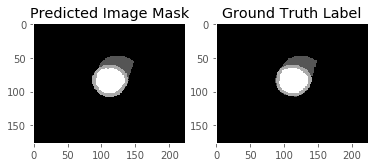

In [20]:
_, ax = plt.subplots(1,2)
ax[0].imshow(pred, cmap='gray')
ax[0].set_title('Predicted Image Mask')
ax[0].grid(False)
ax[1].imshow(y_proj,cmap='gray')
ax[1].set_title('Ground Truth Label')
ax[1].grid(False)

In [21]:
eps = 10**(-3)
imdiff = np.zeros_like(pred)
imdiff[abs(pred-y_proj)>eps] = 1

Text(0.5, 1.0, 'Difference between prediction and ground truth')

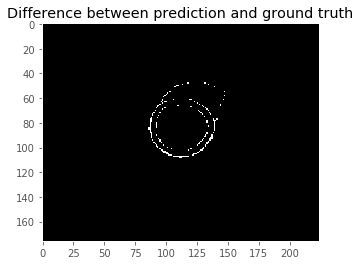

In [22]:
plt.imshow(imdiff, cmap='gray')
plt.grid(False)
plt.title('Difference between prediction and ground truth')

In [23]:
char1 = '('
char2 = ','

train_loss_history = []

with open('data/train_loss_history.txt', 'r') as filehandle:
    for line in filehandle:
        tmp= float(line[line.find(char1)+1:line.find(char2)])
        train_loss_history.append(tmp)
        
val_loss_history = []

with open('data/val_loss_history.txt', 'r') as filehandle:
    for line in filehandle:
        tmp= float(line[line.find(char1)+1:line.find(char2)])
        val_loss_history.append(tmp)
        
train_accuracy_history = []

with open('data/train_accuracy_history.txt', 'r') as filehandle:
    for line in filehandle:
        tmp= float(line[line.find(char1)+1:line.find(char2)])
        train_accuracy_history.append(tmp)
        
val_accuracy_history = []

with open('data/val_accuracy_history.txt', 'r') as filehandle:
    for line in filehandle:
        tmp= float(line[line.find(char1)+1:line.find(char2)])
        val_accuracy_history.append(tmp)

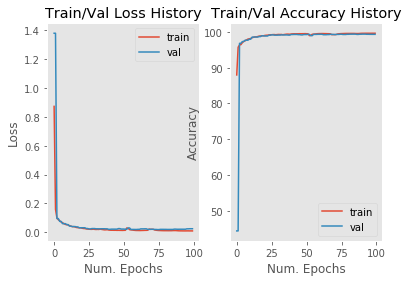

In [25]:
_, ax = plt.subplots(1,2)
length = range(len(train_loss_history))
ax[0].plot(length, train_loss_history, label="train")
ax[0].plot(length, val_loss_history, label="val")
ax[0].grid(False)
ax[0].set_title('Train/Val Loss History')
ax[0].set_xlabel('Num. Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(length, train_accuracy_history, label="train")
ax[1].plot(length, val_accuracy_history, label="val")
ax[1].grid(False)
ax[1].set_title('Train/Val Accuracy History')
ax[1].set_xlabel('Num. Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

In [88]:
round_to = np.unique(pred)
def closest(lst, K):  
    idx = (np.abs(lst - K)).argmin() 
    return lst[idx] 

In [89]:
from skimage.transform import resize

pred = resize(pred, (216,256)) #Resize to original size
pred = (pred-np.amin(pred))/np.amax(pred)

for m in range(216):
    for n in range(256):
        pred[m,n] = closest(round_to, pred[m,n])

In [92]:
tmpLV = np.zeros_like(pred)
tmpLV[pred == round_to[3]] = 1
LV_volume = 1.525*np.sum(tmpLV)

tmpRV = np.zeros_like(pred)
tmpRV[pred == round_to[1]] = 1
RV_volume = 1.525*np.sum(tmpRV)

print(LV_volume, RV_volume)

2635.2 1723.25


In [80]:
pred.shape

(216, 256)

In [91]:
round_to


array([0.        , 0.33333333, 0.66666667, 1.        ])